In [ ]:
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib sklearn seaborn

In [219]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import os
import zipfile

import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing  import sequence
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.layers import Input, Dense, Embedding, Dot, Reshape, GlobalAveragePooling1D
from tensorflow.keras.models import Model

(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k', split = (tfds.Split.TRAIN, tfds.Split.TEST), with_info=True, as_supervised=True)
# print(info)

In [220]:
encoder = info.features['text'].encoder
for data in train_data.take(1):  # Only take a single example
    print("Text:  {}".format(encoder.decode(data[0])))
    print("Label: {}".format(data[1].numpy()))

Text:  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: 0


In [221]:
padded_shapes = ([None],())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)

In [222]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[ 173,   29,    4, ...,    0,    0,    0],
       [  14,    9,    1, ...,    0,    0,    0],
       [7984, 7986, 7976, ...,    0,    0,    0],
       ...,
       [5471, 4002, 1111, ...,    0,    0,    0],
       [  62,   57,    7, ...,    0,    0,    0],
       [  62, 1411,  764, ..., 7976,  283, 7975]])

In [223]:
embedding_dim=16

model = Sequential([
    Embedding(encoder.vocab_size, embedding_dim),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [224]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 8s 3ms/step - loss: 0.5166 - accuracy: 0.6888 - val_loss: 0.3486 - val_accuracy: 0.8600
Epoch 2/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2879 - accuracy: 0.8796 - val_loss: 0.3107 - val_accuracy: 0.9000
Epoch 3/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2345 - accuracy: 0.9070 - val_loss: 0.3655 - val_accuracy: 0.8550
Epoch 4/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2010 - accuracy: 0.9220 - val_loss: 0.2841 - val_accuracy: 0.8850
Epoch 5/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1768 - accuracy: 0.9344 - val_loss: 0.2958 - val_accuracy: 0.8950
Epoch 6/10
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1592 - accuracy: 0.9417 - val_loss: 0.3211 - val_accuracy: 0.8600
Epoch 7/10
2500/2500 [==============================] - 4s 2ms/step - loss: 0.1451 - accuracy: 0.9475 - val_loss: 0.3504 - val_accuracy:

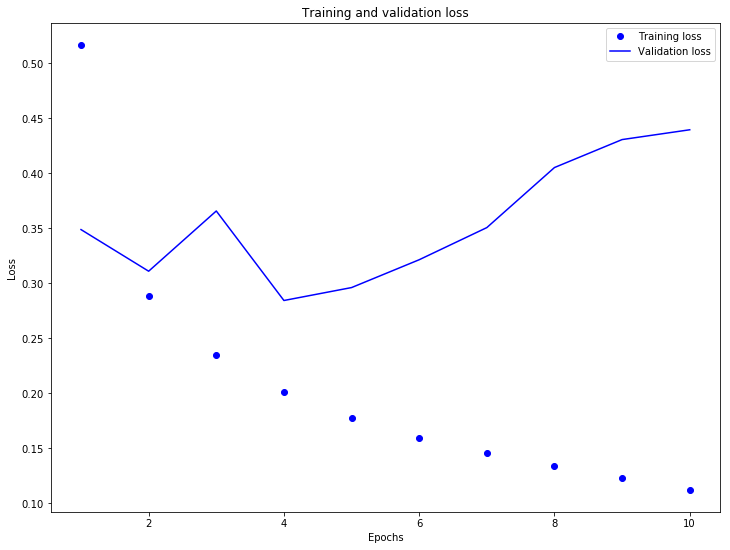

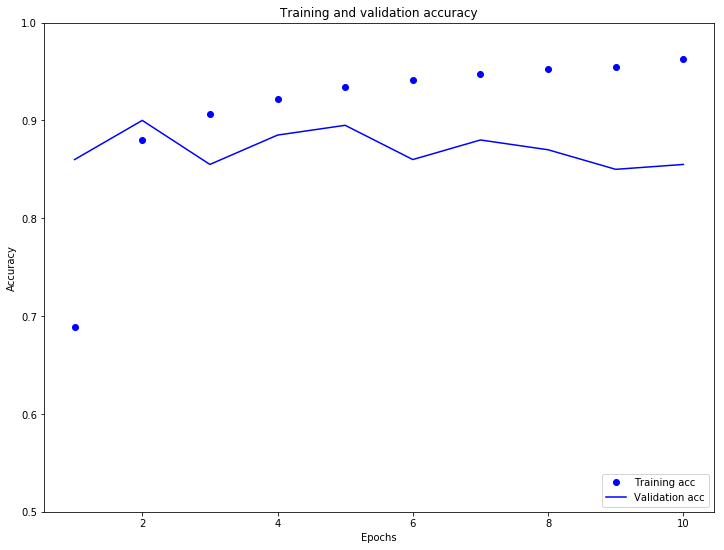

In [226]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [227]:
# Extract embeddings
e = model.layers[0]
weights = e.get_weights()[0]
weights.shape # shape: (vocab_size, embedding_dim)

(8185, 16)

In [228]:
from sklearn.metrics.pairwise import cosine_similarity

encoder = info.features['text'].encoder
words_embeddings = [weights[encoder.encode(word)[0]] for word in encoder.subwords[:encoder.vocab_size]]
np.array(words_embeddings)

array([[ 0.08213642, -0.08443247,  0.11784382, ...,  0.11097765,
        -0.09109391, -0.14208445],
       [ 0.06091855,  0.00126312,  0.06004091, ...,  0.0136017 ,
        -0.06243364, -0.05980629],
       [-0.00347523,  0.03498939,  0.00894806, ..., -0.0749051 ,
         0.01183324, -0.02200872],
       ...,
       [ 0.21736255, -0.21266337,  0.19476217, ...,  0.16740245,
        -0.18679474, -0.23785387],
       [-0.5837804 ,  0.624054  , -0.6071596 , ..., -0.5899954 ,
         0.6072272 ,  0.6345965 ],
       [ 0.17154509, -0.15438806,  0.1483896 , ...,  0.17750171,
        -0.15619126, -0.20422187]], dtype=float32)

In [305]:
predictions = cosine_similarity(weights[encoder.encode("satisfying")[0]].reshape(1, -1), words_embeddings[:encoder.vocab_size])
predictions = (-predictions).argsort()[0][:20]
for i in predictions:
    print(encoder.subwords[i])

satisfying
everyone_
everyone
refreshing
lonel
perfectly_
perfect_
perfect
Carre
moving
moving_
touching_
touch_
touch
ride_
ride
superb
superb_
High
High_


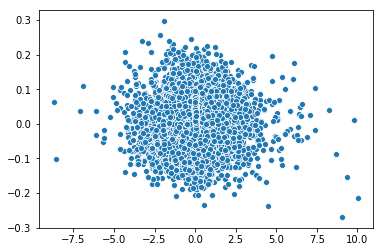

In [245]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8185 samples in 0.007s...
[t-SNE] Computed neighbors for 8185 samples in 0.584s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8185
[t-SNE] Computed conditional probabilities for sample 2000 / 8185
[t-SNE] Computed conditional probabilities for sample 3000 / 8185
[t-SNE] Computed conditional probabilities for sample 4000 / 8185
[t-SNE] Computed conditional probabilities for sample 5000 / 8185
[t-SNE] Computed conditional probabilities for sample 6000 / 8185
[t-SNE] Computed conditional probabilities for sample 7000 / 8185
[t-SNE] Computed conditional probabilities for sample 8000 / 8185
[t-SNE] Computed conditional probabilities for sample 8185 / 8185
[t-SNE] Mean sigma: 0.066610
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.929016
[t-SNE] KL divergence after 300 iterations: 2.227965


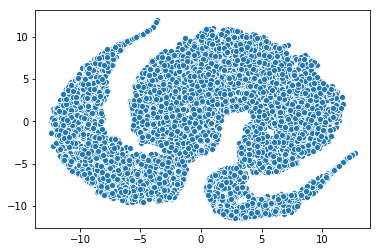

In [72]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(weights)
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])